# **Part 1: Build VAE Model**

In [0]:
 from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from random import sample

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K

batch_size = 100
original_dim = 784
latent_dim = 20 ###latent dimension of 50 and 100 were also tried
intermediate_dim = 256
epochs = 10

#load data
(x_train, y_train_), (x_test, y_test_) = tf.keras.datasets.fashion_mnist.load_data()
x_train3 = x_train.astype('float32') / 255.
x_test3 = x_test.astype('float32') / 255.
x_train2 = x_train3.reshape((len(x_train3), np.prod(x_train3.shape[1:])))
x_test2 = x_test3.reshape((len(x_test3), np.prod(x_test3.shape[1:])))


In [0]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

#conditional mean and variance of z
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [0]:
import warnings
warnings.filterwarnings('ignore')

#Construct decoder network
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

#Build VAE Model
vae = Model(x, x_decoded_mean)

#The loss is composed of reconstruction loss and KL loss
reconstr_loss = K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=-1)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(reconstr_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

#Fit VAE model
vae.fit(x_train2,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test2, None))

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 20)           5140        dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 20)           5140        dense_1[0][0]                    
____________________________________________________________________________________________

In [0]:
#Construct encoder network
encoder = Model(x, z_mean)

#Construct decoder network
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
decoder = Model(decoder_input, _x_decoded_mean)

# **Part 2: Check Generative Model**

In [0]:
#Generate sample from standard multinomial Gaussian Distribution 
#They are the inputs of decoder network
mu=np.zeros(20)
cov=np.eye(20)
np.random.seed(1337)
random_dist=decoder.predict(np.random.multivariate_normal(mu,cov,60000))

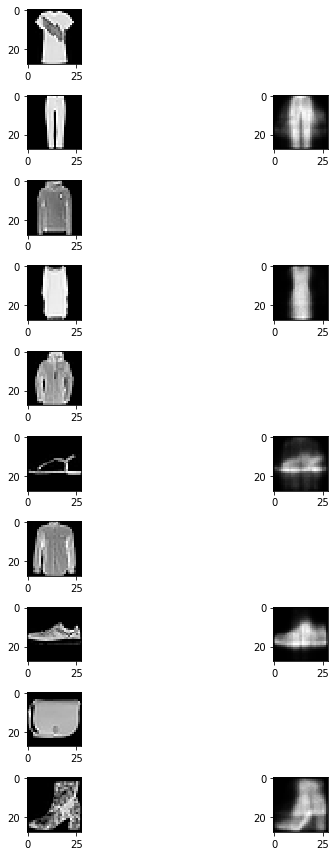

In [0]:
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(8, 12))

for i in range(10):

  #Get a random original sample for each of the ten categories for comparison
  #For generated sample, select some of the most clear ones

  idx=np.array(np.where(y_train_==i))[0][sample(list(range(0,6000)),1)]
  plt.subplot(10, 2, 2*i+1)
  plt.imshow(x_train[idx].reshape(28, 28), cmap="gray")
  plt.subplot(10, 2, 4)
  plt.imshow(random_dist[8].reshape(28, 28), cmap="gray")
  plt.subplot(10, 2, 8)
  plt.imshow(random_dist[9700].reshape(28, 28), cmap="gray")
  plt.subplot(10, 2, 12)
  plt.imshow(random_dist[9000].reshape(28, 28), cmap="gray")
  plt.subplot(10, 2, 16)
  plt.imshow(random_dist[55].reshape(28, 28), cmap="gray")
  plt.subplot(10, 2, 20)
  plt.imshow(random_dist[48].reshape(28, 28), cmap="gray")
plt.tight_layout()

# **Part 3: Check Inference Network**

In [0]:
x_train_encoded = encoder.predict(x_train2, batch_size=batch_size)  #generate hidden variables, 60000*20
x_train_decoded = decoder.predict(x_train_encoded) #run through decoder network, 60000*784

In [0]:
image_idx=sample(list(range(0,60000)),5)
image_sample=x_train_encoded[image_idx] #get 5 random samples

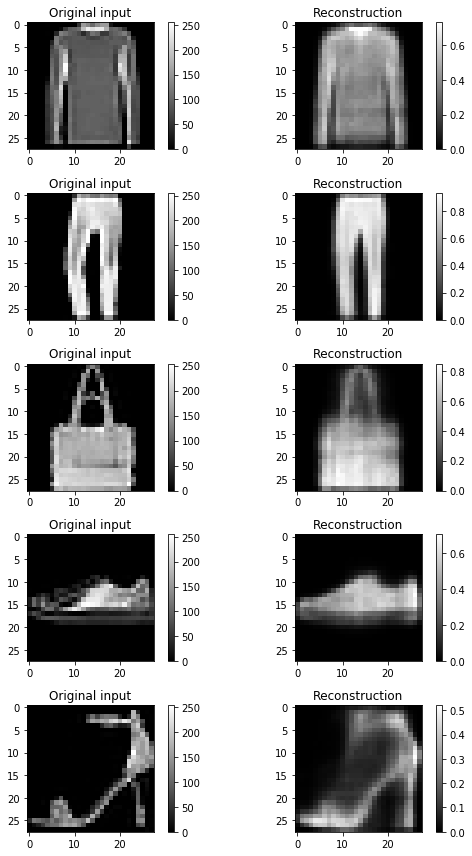

In [0]:
plt.figure(figsize=(8, 12))

for i in range(5):

    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_train[image_idx][i].reshape(28, 28), cmap="gray")
    plt.title("Original input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(decoder.predict(image_sample)[i].reshape(28, 28),  cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
    
plt.tight_layout()

# **Part 4: Classifiers**
### Take the images in your dataset,and feed them through the inference network to obtain the corresponding hidden variables.

In [0]:
#Generate hidden variables of test set, 10000*20
x_test_encoded=encoder.predict(x_test2, batch_size=batch_size) 

## VAE + logistic regression
###  Next, use the values of those hidden variables as the input to a logistic regression that predicts the class labels. You should repeat this process in two regimes: one where you train the logistic regression classifier on a small subset of the data, and another where you use a larger subset. Evaluate the resulting test error against a held-out dataset.


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [0]:
#Logistic Regression for hidden variables, choose solve "saga" for faster computation
logit_model=LogisticRegression(multi_class='multinomial',solver='saga',max_iter=100)

### Larger subset

In [0]:
#Fit logistic regression for 60000 hidden variables 
logit_fit_2=logit_model.fit(x_train_encoded, y_train_) 

In [0]:
train_error_2=np.mean(logit_fit_2.predict(x_train_encoded)!=y_train_) #training error
test_error_2=np.mean(logit_fit_2.predict(x_test_encoded)!=y_test_) #testing error

### Smaller subset

In [0]:
#take a smaller subset(30000)
#Different sample sizes were tried later

sample_idx=sample(list(range(0,60000)),30000)
x_train_encoded_sample=x_train_encoded[sample_idx]
y_train_sample=y_train_[sample_idx]

In [0]:
#Fit logistic regression for 30000 hidden variables 
logit_fit_1=logit_model.fit(x_train_encoded_sample, y_train_sample)  

In [0]:
train_error_1=np.mean(logit_fit_1.predict(x_train_encoded_sample)!=y_train_sample) #training error
test_error_1=np.mean(logit_fit_1.predict(x_test_encoded)!=y_test_) #testing error

In [0]:
print('Test error')
print('\nLarge (60000):', test_error_2)
print('\nSmall (30000):', test_error_1)

Test error

Large (60000): 0.1955

Small (30000): 0.1958


## VAE + simple CNN
### Do this again using a more flexible classifier: use a simple CNN (one convolutional layer and one fully connected layer) instead of logistic regression.
   

In [0]:
from keras.layers import Dense, Activation, Convolution2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from keras.models import Sequential
from keras.optimizers import Adam

In [0]:
#Convert to categorical variables
y_train = np_utils.to_categorical(y_train_, num_classes=10)
y_test = np_utils.to_categorical(y_test_, num_classes=10)

In [0]:
#Seperate the hidden variables into training set and validation set
#Validation set is set to be 1/6 of the sample data
#Thus it uses 5/6 of the sample data to train
#Different sample sizes were tried later

x_train_decoded1=x_train_decoded.reshape(-1, 1,28, 28)
x_test1=x_test2.reshape(-1, 1,28, 28)
x_train_decoded_sample = decoder.predict(x_train_encoded_sample)
x_train_decoded_sample1=x_train_decoded_sample.reshape(-1, 1,28, 28)
x_train_decoded_sample_val=x_train_decoded_sample1[-5000:]
x_train_decoded_sample2=x_train_decoded_sample1[:-5000]
y_train_small=y_train[sample_idx]
y_train_small_val=y_train_small[-5000:]
y_train_small1=y_train_small[:-5000]
x_test_decoded = decoder.predict(x_test_encoded)
x_test_decoded1=x_test_decoded.reshape(-1, 1,28, 28)
x_train_decoded_val=x_train_decoded1[-10000:]
x_train_decoded2=x_train_decoded1[:-10000]
y_train_val=y_train[-10000:]
y_train1=y_train[:-10000]

In [0]:
#Construct simple CNN, with one convolutional layer and one fully connected layer
model_simple = Sequential()

model_simple.add(Convolution2D(
    input_shape=(1, 28, 28),
    filters=32,
    kernel_size=5,
    strides=1,
    padding='same',     
    activation = 'relu',
    data_format='channels_first',
))
model_simple.add(Flatten())
model_simple.add(Dense(10, activation='softmax'))

adam = Adam(lr=1e-4)
model_simple.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

### Larger subset

In [0]:
#Fit simple CNN for 60000 hidden variables 
model_simple.fit(x_train_decoded2, y_train1, batch_size=100, 
                 epochs=3,validation_data=(x_train_decoded_val,y_train_val))

#Get loss and prediction accuracy (Also run epoch = 5 later)
loss, accuracy1 = model_simple.evaluate(x_test_decoded1, y_test,batch_size=100,)

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 39s 779us/step - loss: 0.8256 - acc: 0.7163 - val_loss: 0.6269 - val_acc: 0.7651
Epoch 2/3
50000/50000 [==============================] - 37s 740us/step - loss: 0.5961 - acc: 0.7817 - val_loss: 0.5802 - val_acc: 0.7807
Epoch 3/3
10000/10000 [==============================] - 2s 247us/step


### Smaller subset

In [0]:
#Fit simple CNN for 30000 hidden variables 
model_simple.fit(x_train_decoded_sample2, y_train_small1,epochs=3, batch_size=100,validation_data=(x_train_decoded_sample_val,y_train_small_val))

#Get loss and prediction accuracy (Also run epoch = 5 later)
loss, accuracy = model_simple.evaluate(x_test_decoded1, y_test, batch_size=100,)

Train on 25000 samples, validate on 5000 samples
Epoch 1/3
25000/25000 [==============================] - 22s 873us/step - loss: 0.9938 - acc: 0.6694 - val_loss: 0.7014 - val_acc: 0.7392
Epoch 2/3
25000/25000 [==============================] - 20s 782us/step - loss: 0.6426 - acc: 0.7622 - val_loss: 0.6301 - val_acc: 0.7636
Epoch 3/3
10000/10000 [==============================] - 3s 268us/step


In [0]:
print('Test error')
print('\nLarge (60000):', 1-accuracy1)
print('\nSmall (30000):', 1-accuracy)

Test error

Large (60000): 0.21260000228881837

Small (30000): 0.224200000166893


## Multilayer CNN
###  Compare the results of this process to directly training a multilayer CNN classifier on the original data, both in the setting where we train only on the small subset of the data, and the larger subset.

In [0]:
#Seperate the original data into training set and validation set
#Validation set is set to be 1/6 of the sample data
#Thus it uses 5/6 of the sample data to train
#Different sample sizes were tried later

x_train1 = x_train2.reshape(-1, 1,28, 28)
x_test1=x_test2.reshape(-1, 1,28, 28)
x_train_val=x_train1[-10000:]
x_train_mlarge=x_train1[:-10000]
y_train_val1=y_train[-10000:]
y_train_mlarge=y_train[:-10000]
sample_idx1=sample(list(range(0,60000)),30000)
x_train_mval=x_train1[sample_idx1][-5000:]
x_train_msmall=x_train1[sample_idx1][:-5000]
y_train_mval=y_train[sample_idx1][-5000:]
y_train_msmall=y_train[sample_idx1][:-5000]

In [0]:
#Conctruct multiplayer CNN; here CNN with 2 layers were built

model_multi = Sequential()

# Conv layer 1 output shape (32, 28, 28)
model_multi.add(Convolution2D(
    batch_input_shape=(None, 1, 28, 28),
    filters=32,
    kernel_size=5,
    strides=1,
    padding='same',     # Padding method
    data_format='channels_first',
))
model_multi.add(Activation('relu'))

# Pooling layer 1 (max pooling) output shape (32, 14, 14)
model_multi.add(MaxPooling2D(
    pool_size=2,
    strides=2,
    padding='same',    # Padding method
    data_format='channels_first',
))

# Conv layer 2 output shape (64, 14, 14)
model_multi.add(Convolution2D(64, 5, strides=1, padding='same', data_format='channels_first'))
model_multi.add(Activation('relu'))

# Pooling layer 2 (max pooling) output shape (64, 7, 7)
model_multi.add(MaxPooling2D(2, 2, 'same', data_format='channels_first'))

# Fully connected layer 1 input shape (64 * 7 * 7) = (3136), output shape (1024)
model_multi.add(Flatten())
model_multi.add(Dense(1024))
model_multi.add(Activation('relu'))

# Fully connected layer 2 to shape (10) for 10 classes
model_multi.add(Dense(10))
model_multi.add(Activation('softmax'))

adam = Adam(lr=1e-4)

model_multi.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Larger subset

In [0]:
#Fit multilayer CNN for 60000 samples
model_multi.fit(x_train_mlarge,y_train_mlarge, epochs=3, batch_size=100,validation_data=(x_train_val,y_train_val1))

#Get loss and accuracy (Also run epoch = 5 later)
loss, accuracy2 = model_multi.evaluate(x_test1, y_test,batch_size=100,)

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 190s 4ms/step - loss: 0.6569 - acc: 0.7773 - val_loss: 0.4738 - val_acc: 0.8303
Epoch 2/3
50000/50000 [==============================] - 188s 4ms/step - loss: 0.4153 - acc: 0.8531 - val_loss: 0.4203 - val_acc: 0.8502
Epoch 3/3
10000/10000 [==============================] - 10s 959us/step


### Smaller subset

In [0]:
#Fit multilayer CNN for 30000 samples
model_multi.fit(x_train_msmall, y_train_msmall, epochs=4, batch_size=100,validation_data=(x_train_mval,y_train_mval))

#Get loss and accuracy (Also run epoch = 5 later)
loss, accuracy3 = model_multi.evaluate(x_test1, y_test,batch_size=100,)

Train on 25000 samples, validate on 5000 samples
Epoch 1/4
25000/25000 [==============================] - 97s 4ms/step - loss: 0.8326 - acc: 0.7185 - val_loss: 0.5274 - val_acc: 0.8170
Epoch 2/4
25000/25000 [==============================] - 94s 4ms/step - loss: 0.4981 - acc: 0.8194 - val_loss: 0.4612 - val_acc: 0.8316
Epoch 3/4
25000/25000 [==============================] - 94s 4ms/step - loss: 0.4286 - acc: 0.8490 - val_loss: 0.4085 - val_acc: 0.8590
Epoch 4/4
10000/10000 [==============================] - 9s 948us/step


In [0]:
print('Test error')
print('\nLarge (60000):', 1-accuracy2)
print('\nSmall (30000):', 1-accuracy3)

Test error

Large (60000): 0.1314000010490417

Small (30000): 0.14490000188350682


### Discuss how the performance of the three methods (VAE + logistic regression, VAE + simple CNN, and multilayer CNN) varies across different data regimes. Which is better in which setting? In the ‘small labelled data’ regime, where we trained our classifier on a small number of samples, did the dimensionality reduction from the VAE help the simpler classifiers to achieve a better test error than the multilayer CNN classifier?

VAE + logistic regression: The test errors for large and small data regimes are similar. 

Large (60000): 0.1955

Small (30000): 0.1958

\
VAE + simple CNN: Large subset has lower error.

Large (60000): 0.21260000228881837

Small (30000): 0.224200000166893

\
Multilayer CNN: Large subset has lower error.

Large (60000): 0.1314000010490417

Small (30000): 0.14490000188350682

\
In small labeled data, dimensionality reduction does not help with the accuracy. Multilayer CNN still has a better error.

**In order to compare the effect of different training sizes on the test errors of classification, we tried 20000, 30000, 40000, 50000, 60000 samples to train our classifiers. For each classifier, we also tried different latent dimension: 20(which is the dimension we used to build VAE model),50 and 100.**

---

 ## The results of the followings are summarized in result part in the report.

In [0]:
#####################################
######VAE + Logistic Regression######
#####################################

from sklearn.linear_model import LogisticRegressionCV

print('Latent Dimension = 100')

logit_model=LogisticRegressionCV(cv=5,multi_class='multinomial',solver='sag',max_iter=100)

###Smaller sample
size=np.array([20000,30000,40000,50000])
for size in size:
  sample_idx=sample(list(range(0,60000)),size)
  x_train_encoded_sample=x_train_encoded[sample_idx]
  y_train_sample=y_train_[sample_idx]  

  logit_fit=logit_model.fit(x_train_encoded_sample, y_train_sample)

  train_error=np.mean(logit_fit.predict(x_train_encoded_sample)!=y_train_sample) 
  test_error=np.mean(logit_fit.predict(x_test_encoded)!=y_test_)

  print('Training Size =',size,':','Training Error:',train_error,';','Testing Error:',test_error)

###Larger sample(full): 60000
logit_fit_full=logit_model.fit(x_train_encoded, y_train_)

train_error_full=np.mean(logit_fit_full.predict(x_train_encoded)!=y_train_) 
test_error_full=np.mean(logit_fit_full.predict(x_test_encoded)!=y_test_) 

print('Training Size = 60000', ':','Training Error:',train_error_full,';','Testing Error:',test_error_full)


In [0]:
############################
######VAE + Simple CNN######
############################

x_train_encoded = encoder.predict(x_train2, batch_size=batch_size)  #generate hidden variables, 60000*20
x_train_decoded = generator.predict(x_train_encoded).reshape(-1, 1,28, 28)
x_test_encoded=encoder.predict(x_test2, batch_size=batch_size) #10000*20
x_test_decoded = generator.predict(x_test_encoded).reshape(-1, 1,28, 28)

In [0]:
size=np.array([20000,30000,40000,50000,60000])

for size in size:

  model_simple = Sequential()
  
  model_simple.add(Convolution2D(
      input_shape=(1, 28, 28),
      filters=32,
      kernel_size=5,
      strides=1,
      padding='same',     
      activation = 'relu',
      data_format='channels_first',
  ))
  model_simple.add(Flatten())
  model_simple.add(Dense(10, activation='softmax'))


  adam = Adam(lr=1e-4)
  model_simple.compile(loss='categorical_crossentropy',
                optimizer=adam,
                metrics=['accuracy'])
  
  sample_idx=sample(list(range(0,60000)),size)

  x_train_encoded_sample=x_train_encoded[sample_idx]

  x_train_decoded_sample = generator.predict(x_train_encoded_sample).reshape(-1, 1,28, 28) ###take sample(20000-60000)

  x_decoded_val=x_train_decoded_sample[-int(size/6):] #get validation set of x
  x_train_decoded=x_train_decoded_sample[:-int(size/6)]

  y_train_sample=y_train[sample_idx] #get validation set of y
  y_val=y_train_sample[-int(size/6):]
  y_train_small=y_train_sample[:-int(size/6)]

  model_simple.fit(x_train_decoded, y_train_small,epochs=5, batch_size=100,validation_data=(x_decoded_val,y_val) )

  loss, accuracy = model_simple.evaluate(x_test_decoded, y_test, batch_size=100,)
  print('Sample Size= ',size, 'Testing Error = ',1-accuracy)

In [0]:
###########################
######Multiplayer CNN######
###########################

size=np.array([20000,30000,40000,50000,60000])
for size in size:

  model_multi = Sequential()

  model_multi.add(Convolution2D(
    batch_input_shape=(None, 1, 28, 28),
    filters=32,
    kernel_size=5,
    strides=1,
    padding='same',     
    data_format='channels_first',
  ))
  model_multi.add(Activation('relu'))

  model_multi.add(MaxPooling2D(
    pool_size=2,
    strides=2,
    padding='same',   
    data_format='channels_first',
  ))

  model_multi.add(Convolution2D(64, 5, strides=1, padding='same', data_format='channels_first'))
  model_multi.add(Activation('relu'))

  model_multi.add(MaxPooling2D(2, 2, 'same', data_format='channels_first'))

  model_multi.add(Flatten())
  model_multi.add(Dense(1024))
  model_multi.add(Activation('relu'))

  model_multi.add(Dense(10))
  model_multi.add(Activation('softmax'))

  adam = Adam(lr=1e-4)

  model_multi.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy']) 
  
  sample_idx=sample(list(range(0,60000)),size)

  #Get validation set of x
  x_val=x_train1[sample_idx][-int(size/6):] 
  x_train_small=x_train1[sample_idx][:-int(size/6)]

  #Get validation set of y
  y_val=y_train[sample_idx][-int(size/6):]
  y_train_small=y_train[sample_idx][:-int(size/6)]
 
  model_multi.fit(x_train_small, y_train_small, epochs=5, batch_size=100,validation_data=(x_val,y_val))

  loss, accuracy = model_multi.evaluate(x_test1, y_test,batch_size=100,)

  print('Training Size =',size,':','Testing Error:', 1-accuracy)